## List of tables:
### 1. [Table 3: Treatment effects](#quantity)

## List of figures:
### 2. [Figure 1: Distribution of fragments submitted](#icdf)

In [1]:
%matplotlib inline

#### Imports libraries

In [2]:
import matplotlib.pyplot as plt  # Plotting
import os  # File system handling
import pandas as pd  # Dataframe handling
import statsmodels.formula.api as smf  # Regressions analysis

from matplotlib.ticker import FuncFormatter  # Formating graphs
from itertools import combinations
from statsmodels.iolib.summary2 import summary_col  # Regression output table
from statsmodels.stats.proportion import proportions_ztest # Proportion Z-test

#### Set project directory

In [3]:
PROJECT_FOLDER = os.path.dirname(os.getcwd())
FINAL_DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data', 'final')
TABLES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'tables')
FIGURES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'figures')

#### Pandas options

In [4]:
pd.set_option("display.precision", 3)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_rows", 40)

#### Set plotting style

In [5]:
plt.style.use('classic')

#### Set plotting properties 

In [6]:
bar_kw = dict(kind='bar', color='0.4')
line_kw = dict(kind='line', lw=1, alpha=1, legend=True)
font_kw = dict(fontsize=11, color='k')
grid_kw = dict(linewidth=1, axis="y", zorder=2, antialiased=True)
xlab_kw = dict(fontsize=11, labelpad=3)
ylab_kw = dict(fontsize=11, labelpad=3)
error_kw = dict(elinewidth=2, ecolor='0.15')
legend_kw = dict(frameon=False)
tick_kw = dict(size=5,
               which='both',
               direction='out',
               right=False,
               top=False,
               labelbottom=True)

#### Retrieving dataframe

In [7]:
DATA = os.path.join(
    FINAL_DATA_FOLDER, 
    'fair_advice_final.feather'
)

df = pd.read_feather(DATA)

#### Select only dictators and no-risk treatments

In [8]:
df = df[(df['Dictator'] == 1) & (df['Risk'] == 0)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 903 entries, 1799 to 3597
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Dataset                   903 non-null    int64         
 1   SubmitTime                903 non-null    datetime64[ns]
 2   Duration                  903 non-null    int64         
 3   Controlquestion           903 non-null    float64       
 4   Controlquestion_attempts  903 non-null    float64       
 5   Treatment                 903 non-null    int64         
 6   Treatment_name            903 non-null    object        
 7   Dictator                  903 non-null    int64         
 8   Decision                  903 non-null    int64         
 9   Advise                    0 non-null      float64       
 10  Follow                    0 non-null      float64       
 11  Belief1                   302 non-null    float64       
 12  Belief2           

#### Group according to treatments

In [9]:
grouped_advice = df.groupby('Advice_type')

#### Control questions attempts

In [10]:
grouped_advice['Controlquestion_attempts'].value_counts()

Advice_type  Controlquestion_attempts
Base         0.0                         304
Binding      0.0                         295
             1.0                           2
Free         0.0                         302
Name: Controlquestion_attempts, dtype: int64

#### Proportion of players who choose selfish

In [11]:
decision_advice = grouped_advice['Decision']\
    .agg(['mean', 'sem', 'count'])\
    .rename(lambda x: x.capitalize(), axis=0)

display(decision_advice)

,mean,sem,count
Advice_type,,,
Base,0.553,0.029,304
Binding,0.418,0.029,297
Free,0.354,0.028,302


#### Pairwise proportion Z-test for proportion of selfish players

In [12]:
for group_1, group_2 in combinations(['Base', 'Binding', 'Free'], 2):
    nobs = ((df[f'{group_1}'] == 1).sum()), ((df[f'{group_2}'] == 1).sum())
    count_selfish = df[df[f'{group_1}'] == 1]['Decision'].sum(), df[df[f'{group_2}'] == 1]['Decision'].sum()
    zstat, pvalue = proportions_ztest(count_selfish, nobs)
    print(f'{group_1} vs. {group_2}: Z-stat: {zstat:.3f}, P-value: {pvalue:.3f}')

Base vs. Binding: Z-stat: 3.314, P-value: 0.001
Base vs. Free: Z-stat: 4.903, P-value: 0.000
Binding vs. Free: Z-stat: 1.589, P-value: 0.112


#### Plot share of selfish choices

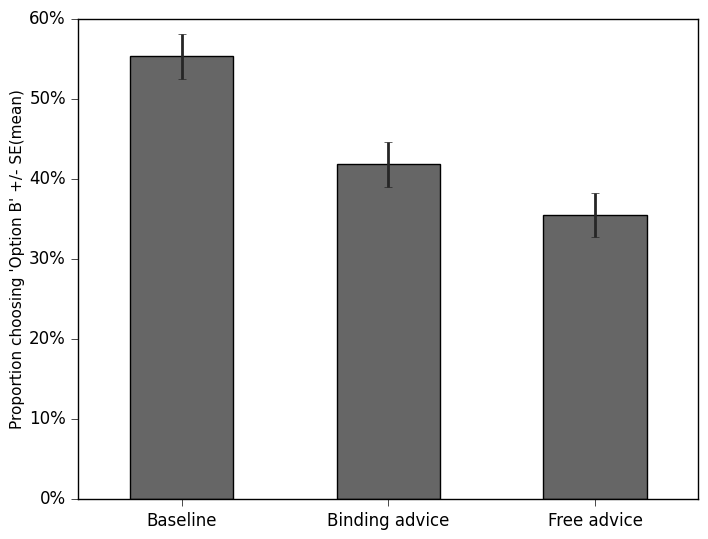

In [24]:
fig, ax = plt.subplots(
    figsize=(8, 6), 
    dpi=100, 
    facecolor='w'
)

decision_advice['mean'].plot(
    yerr=decision_advice['sem'], 
    ax=ax, 
    error_kw=error_kw, 
    **bar_kw
)

ax.set_ylabel("Proportion choosing 'Option B' +/- SE(mean)", **ylab_kw)
ax.set_xlabel("")
ax.set_xticklabels(['Baseline', 'Binding advice', 'Free advice'])
ax.tick_params(rotation=0, **tick_kw)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

path = os.path.join(
    FIGURES_FOLDER,  
    'decision_advice.pdf'
)
fig.savefig(path, bbox_inches='tight')

#### Table 3: Estimating treatment effects using OLS <a id='quantity'></a>

In [14]:
regs = dict()
regs['reg1'] = 'Decision ~ Binding + Free'
regs['reg2'] = regs['reg1'] + ' + Age_m + Female + Education_m + Political_m'

ols_results = [smf.ols(formula=v, data=df).fit(cov_type='HC1') for v in regs.values()]

order = [
    'Binding',
    'Free',
    'Age_m',
    'Female',
    'Education_m',
    'Political_m',
    'Intercept',
]

auxiliary = {
    'N': lambda x: f'{x.nobs:.0f}',
    'F': lambda x: f'{x.fvalue:.3f}',
    'P(>F)': lambda x: f'{x.f_pvalue:.3f}'
}

ols_quant = summary_col(
    ols_results,
    stars=True,
    info_dict=auxiliary,
    float_format='%.3f',
    regressor_order=order,
)

ols_quant = ols_quant\
    .tables[0]\
    .rename(mapper=lambda x: x.replace(':', ' * '), axis=0)\
    .rename(mapper=lambda x: x.split()[0].replace('decision_numeric', 'p(selfish)'), axis=1)\
    .rename_axis('Dependent variable:', axis=1)

ols_quant.to_latex(
    os.path.join(TABLES_FOLDER, 'ols_decision.tex'),
    bold_rows=False,
    float_format="%.3f"
)

display(ols_quant)

Dependent variable:,Decision,Decision
Binding,-0.135***,-0.133***
,(0.040),(0.040)
Free,-0.198***,-0.198***
,(0.040),(0.040)
Age_m,,-0.039
,,(0.033)
Female,,-0.126***
,,(0.033)
Education_m,,-0.014
,,(0.033)


#### Estimate linear combination for difference in treatment dummies.

In [17]:
ols_results[0].t_test('Free - Binding = 0').summary()

,coef,std err,z,P>|z|,[0.025,0.975]
c0,-0.0632,0.040,-1.589,0.112,-0.141,0.015


In [18]:
ols_results[1].t_test('Free - Binding = 0').summary()

,coef,std err,z,P>|z|,[0.025,0.975]
c0,-0.0646,0.039,-1.639,0.101,-0.142,0.013


#### Tabulate share of selfish choices, by gender

In [20]:
decision_gender = df.groupby(['Female', 'Advice_type'])['Decision']\
    .agg(['mean', 'sem', 'count'])\
    .rename({0:'Male', 1:'Female'}, axis=0, level=0)\
    .rename({'base': 'Baseline', 'binding':'Binding advice', 'free':'Free advice'}, axis=0, level=1)\
    .rename_axis(('Gender', 'Treatment'), axis=0)\
    .swaplevel()\
    .sort_index()

display(decision_gender)

mean    sem  count
Treatment Gender                     
Base      Female  0.490  0.041    149
          Male    0.613  0.039    155
Binding   Female  0.331  0.039    148
          Male    0.503  0.041    149
Free      Female  0.305  0.038    151
          Male    0.404  0.040    151

#### Plot share of selfish choices, by gender

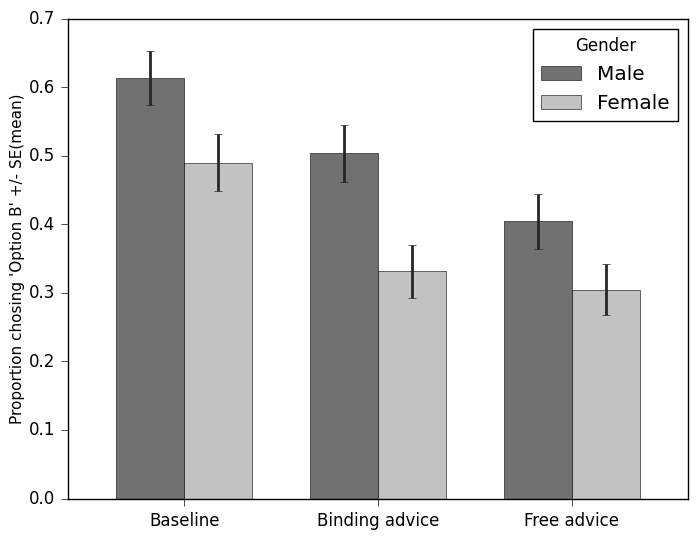

In [23]:
means = decision_gender\
    .loc[:, 'mean']\
    .unstack()\
    .sort_index(axis=1, ascending=False)

errors = decision_gender\
    .loc[:,'sem']\
    .unstack()\
    .sort_index(axis=1, ascending=False)

fig, ax = plt.subplots(
    figsize=(8, 6), 
    dpi=100, 
    facecolor='w'
)

means.plot(
    yerr=errors, 
    ax=ax, 
    capsize=4, 
    kind='bar', 
    error_kw=error_kw, 
    color=['0.3', '0.7'], 
    alpha=0.8, 
    lw=0.5, 
    width=0.7
)
ax.set_ylabel("Proportion chosing 'Option B' +/- SE(mean)", **ylab_kw)
ax.set_xlabel("")
ax.set_xticklabels(['Baseline', 'Binding advice', 'Free advice'])
ax.tick_params(rotation=0, **tick_kw)

In [25]:
regs = dict()
regs['reg1'] = 'Decision ~ (Binding + Free) * Female'
regs['reg2'] = regs['reg1'] + ' + Age_m + Education_m + Political_m'

ols_results = [smf.ols(formula=v, data=df).fit(cov_type='HC1') for v in regs.values()]

order = [
    'Binding',
    'Free',
    'Female',
    'Binding:Female',
    'Free:Female',
    'Intercept',
]

auxiliary = {
    'N': lambda x: f'{x.nobs:.0f}',
    'F': lambda x: f'{x.fvalue:.3f}',
    'P(>F)': lambda x: f'{x.f_pvalue:.3f}'
}

ols_quant = summary_col(
    ols_results,
    stars=True,
    info_dict=auxiliary,
    float_format='%.3f',
    regressor_order=order,
    drop_omitted=True,
)

ols_quant = ols_quant\
    .tables[0]\
    .rename(mapper=lambda x: x.replace(':', ' * '), axis=0)\
    .rename(mapper=lambda x: x.split()[0].replace('Decision', 'p(selfish)'), axis=1)\
    .rename_axis('Dependent variable', axis=1)

# this is bad
h1 = ols_results[0].t_test('Binding + Binding:Female = 0')
h2 = ols_results[1].t_test('Binding + Binding:Female = 0')
h3 = ols_results[0].t_test('Free + Free:Female = 0')
h4 = ols_results[1].t_test('Free + Free:Female = 0')

ols_quant.loc['Binding + Binding:Female'] = pd.Series(
    [f'{h1.effect[0]:.3f}', f'{h2.effect[0]:.3f}'],
    index=ols_quant.columns
)
ols_quant.loc['sd1'] = pd.Series(
    [f'({h1.sd[0][0]:.3f})', f'({h2.sd[0][0]:.3f})'],
    index=ols_quant.columns
)
ols_quant.loc['Free + Free:Female'] = pd.Series(
    [f'{h3.effect[0]:.3f}', f'{h4.effect[0]:.3f}'],
    index=ols_quant.columns
)
ols_quant.loc['sd2'] = pd.Series(
    [f'({h3.sd[0][0]:.3f})', f'({h4.sd[0][0]:.3f})'],
    index=ols_quant.columns
)

ols_quant.to_latex(
    os.path.join(TABLES_FOLDER, 'ols_decision_female.tex'),
    bold_rows=False,
    float_format="%.3f",
    caption='Estimating the probability of player X to choose the selfish option, by gender',
    label='decision_female',
)

display(ols_quant)

Dependent variable,p(selfish),p(selfish)
Binding,-0.110*,-0.110*
,(0.057),(0.057)
Free,-0.209***,-0.210***
,(0.056),(0.056)
Female,-0.123**,-0.119**
,(0.057),(0.057)
Binding * Female,-0.049,-0.047
,(0.080),(0.080)
Free * Female,0.024,0.024
,(0.079),(0.079)


#### Probit

In [26]:
regs = dict()
regs['reg1'] = 'Decision ~ Binding + Free'
regs['reg2'] = regs['reg1'] + ' + Age_m + Female + Education_m + Political_m'

probit_results = [
    smf.probit(formula=v, data=df).fit() for v in regs.values()
]

order = [
    'Binding',
    'Free',
    'Age_m',
    'Female',
    'Education_m',
    'Political_m',
    'Intercept',
]

auxiliary = {
    'N': lambda x: f'{x.nobs:.0f}',
    'PR2': lambda x: f'{x.prsquared:.3f}',
}

probit_decision = summary_col(
    probit_results,
    stars=True,
    info_dict=auxiliary,
    float_format='%.3f',
    regressor_order=order,
)

probit_decision = probit_decision\
    .tables[0]\
    .rename(mapper=lambda x: x.replace(':', ' * '), axis=0)\
    .rename(mapper=lambda x: x.split()[0].replace('Decision', 'p(selfish)'), axis=1)\
    .rename_axis('Dependent variable:', axis=1)

probit_decision.to_latex(
    os.path.join(TABLES_FOLDER, 'probit_decision.tex'),
    bold_rows=False,
    float_format="%.3f"
)

display(probit_decision)

Optimization terminated successfully.
         Current function value: 0.672375
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.662443
         Iterations 4


Dependent variable:,p(selfish),p(selfish)
Binding,-0.341***,-0.341***
,(0.103),(0.104)
Free,-0.506***,-0.512***
,(0.103),(0.104)
Age_m,,-0.101
,,(0.087)
Female,,-0.329***
,,(0.086)
Education_m,,-0.037
,,(0.085)


#### Convert to html

In [27]:
!jupyter nbconvert --output-dir='./docs' --to html 3_treatment_effects.ipynb

[NbConvertApp] Converting notebook 3_treatment_effects.ipynb to html
[NbConvertApp] Writing 719653 bytes to docs/3_treatment_effects.html
